In [15]:
# import libraries
import os
import tarfile
import random
import gc
import warnings
import itertools

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU, ReLU
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report 

warnings.filterwarnings('ignore')

In [16]:
import tensorflow as tf
print(tf.__version__)
print("TensorFlow installed successfully!")

2.20.0
TensorFlow installed successfully!


In [17]:
import pandas as pd

df_train = pd.read_csv('rvsf/train.csv', index_col=0)
df_val = pd.read_csv('rvsf/valid.csv', index_col=0)
df_test = pd.read_csv('rvsf/test.csv', index_col=0)

In [18]:
df_train.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


In [19]:
df_val.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,20001,1,real,valid/real/20001.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11264,1,real,valid/real/11264.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,19817,1,real,valid/real/19817.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,46851,1,real,valid/real/46851.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,10411,1,real,valid/real/10411.jpg


In [20]:
df_test.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg


In [21]:
# remove not needed columns and shuffle
df_train = df_train.drop(columns=['original_path','id','label_str']).sample(frac=1)
df_val = df_val.drop(columns=['original_path','id','label_str']).sample(frac=1)
df_test = df_test.drop(columns=['original_path','id','label_str']).sample(frac=1)

# rectify labels
df_train['label'] = 1 - df_train['label']
df_val['label'] = 1 - df_val['label']
df_test['label'] = 1 - df_test['label']

In [22]:
# split datasets by columns
y_train = df_train['label']
X_train = df_train['path']

y_val = df_val['label']
X_val = df_val['path']

y_test = df_test['label']
X_test = df_test['path']

<BarContainer object of 2 artists>

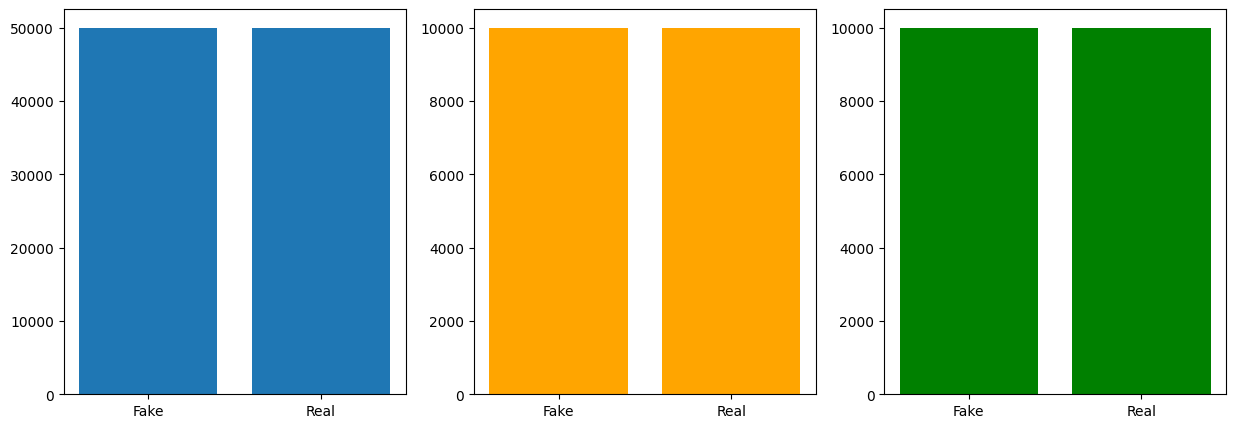

In [23]:
# Check class balance for each dataset
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].bar(y_train.value_counts().index, y_train.value_counts(), tick_label=['Real','Fake'])
axs[1].bar(y_val.value_counts().index, y_val.value_counts(), tick_label=['Real','Fake'], color='orange')
axs[2].bar(y_test.value_counts().index, y_test.value_counts(), tick_label=['Real','Fake'], color='green')

In [24]:
# extract the amount of data to be used
X_train = X_train[:40000]
y_train = y_train[:40000]
X_val = X_val[:4000]
y_val = y_val[:4000]
X_test = X_test[:4000]
y_test = y_test[:4000]

<BarContainer object of 2 artists>

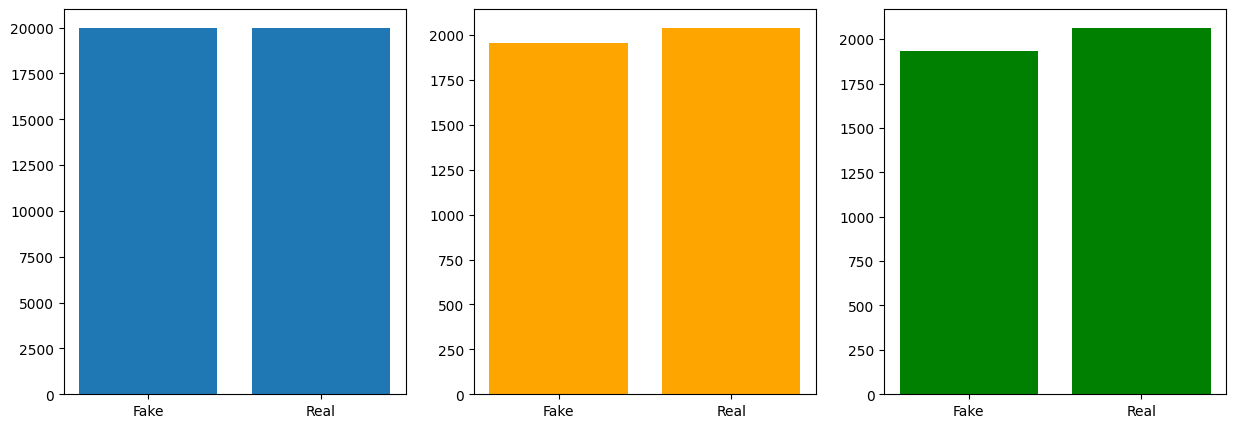

In [25]:
# Check for class balance in extracted data
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].bar(y_train.value_counts().index, y_train.value_counts(), tick_label=['Real','Fake'])
axs[1].bar(y_val.value_counts().index, y_val.value_counts(), tick_label=['Real','Fake'], color='orange')
axs[2].bar(y_test.value_counts().index, y_test.value_counts(), tick_label=['Real','Fake'], color='green')

In [26]:
# (Run this cell only ONCE after restarting the kernel and loading the data)

# Prepend the correct folder structure to the existing paths
X_train = 'rvsf/real_vs_fake/real-vs-fake/' + X_train
X_val   = 'rvsf/real_vs_fake/real-vs-fake/' + X_val
X_test  = 'rvsf/real_vs_fake/real-vs-fake/' + X_test

# --- VERIFY THE RESULT ---
# Print the first path to confirm it's correct now.
print("Corrected path example:")
print(X_train.iloc[0])

# Expected output will now be:
# rvsf/real_vs_fake/real-vs-fake/train/real/57940.jpg

Corrected path example:
rvsf/real_vs_fake/real-vs-fake/train/fake/LU5BTVR069.jpg


Path correction complete.
Example of a corrected relative path:
rvsf/real_vs_fake/real-vs-fake/train/real/31355.jpg

Attempting to plot images...


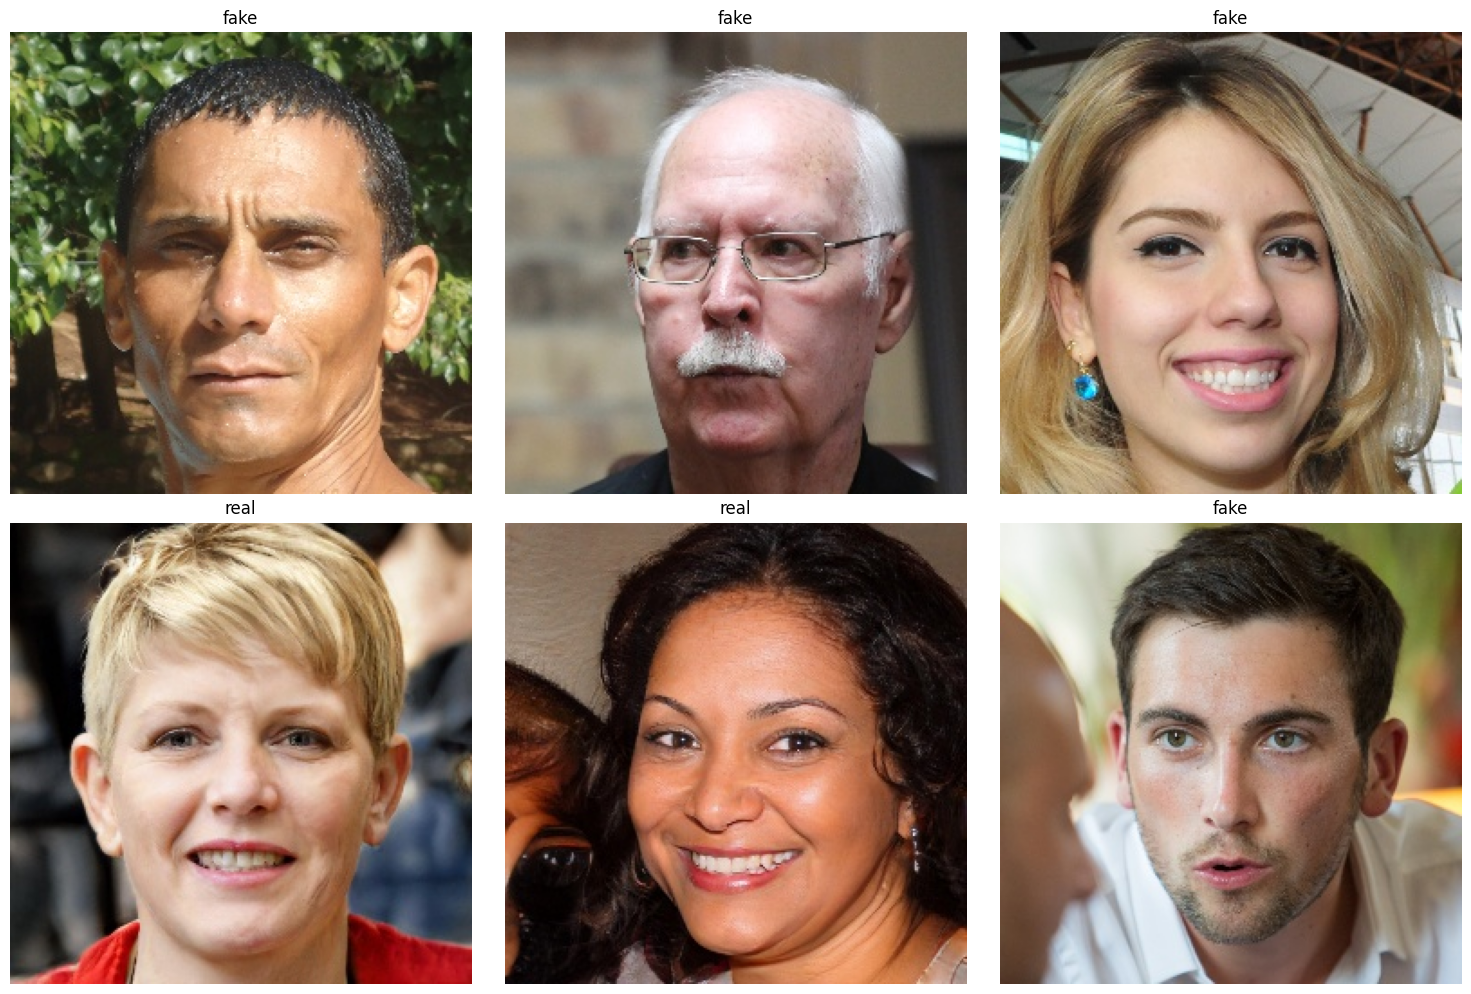


Success! Images plotted correctly.


In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# --- 1. SETUP: Correctly define paths and load data ---

# FIX: The base path must point to your "Project" folder.
BASE_PATH = '/home/vikram/Desktop/Project/' 

# The full path to your training data CSV file
CSV_PATH = os.path.join(BASE_PATH, 'rvsf/train.csv')

try:
    # Load the training data from the now-correct CSV path
    train_df = pd.read_csv(CSV_PATH)
    X_train = train_df['path']
    y_train = train_df['label']
except FileNotFoundError:
    print(f"FATAL ERROR: The CSV file was not found at '{CSV_PATH}'")
    raise

# --- 2. FIX IMAGE PATHS: Prepend the missing folders ---

# This correctly adds the necessary folders to the paths from the CSV
X_train = 'rvsf/real_vs_fake/real-vs-fake/' + X_train
print("Path correction complete.")
print(f"Example of a corrected relative path:\n{X_train.iloc[0]}\n")

# --- 3. PLOT IMAGES: This will now work ---

print("Attempting to plot images...")
label_arg = {0: 'real', 1: 'fake'}
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(2):
    for j in range(3):
        random_idx = np.random.randint(0, X_train.shape[0])
        
        # Construct the complete, absolute path for the image
        img_path = os.path.join(BASE_PATH, X_train.iloc[random_idx])
        
        # This will succeed ✅
        img = Image.open(img_path)
        
        axs[i, j].imshow(img)
        axs[i, j].set_title(label_arg[y_train.iloc[random_idx]])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()
print("\nSuccess! Images plotted correctly.")

In [28]:

# import second dataset and shuffle

df_test_2 = pd.read_csv('hardrvsf/data.csv').sample(frac=1, random_state=42)


In [29]:
# set the path for each image and create numerical labels
df_test_2['images_id'] = df_test_2['images_id'].apply(
    lambda x: 'hardrvsf/real/' + x + '.jpg'
    if x.startswith('real') 
    else 'hardrvsf/fake/' + x + '.jpg'
)

# convert label text to numeric
df_test_2['label'] = df_test_2['label'].map(lambda x: 1 if x == 'fake' else 0)

# rename the column for clarity
df_test_2.rename(columns={'images_id': 'path'}, inplace=True)

# show sample
df_test_2.head()


,path,label
1121,hardrvsf/fake/fake_579.jpg,1
1186,hardrvsf/fake/fake_637.jpg,1
462,hardrvsf/real/real_515.jpg,0
81,hardrvsf/real/real_172.jpg,0
63,hardrvsf/real/real_156.jpg,0


<BarContainer object of 2 artists>

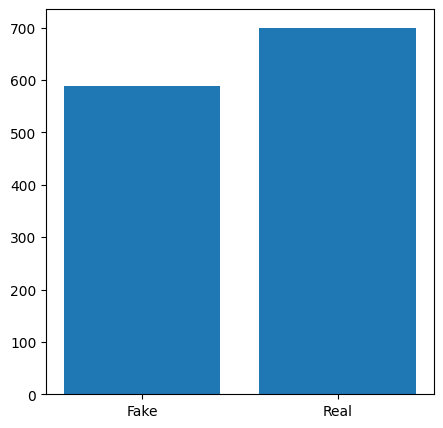

In [30]:
# check the class balance
fig = plt.figure(figsize=(5,5))
plt.bar(df_test_2['label'].value_counts().index, df_test_2['label'].value_counts(), tick_label=['Real','Fake'])

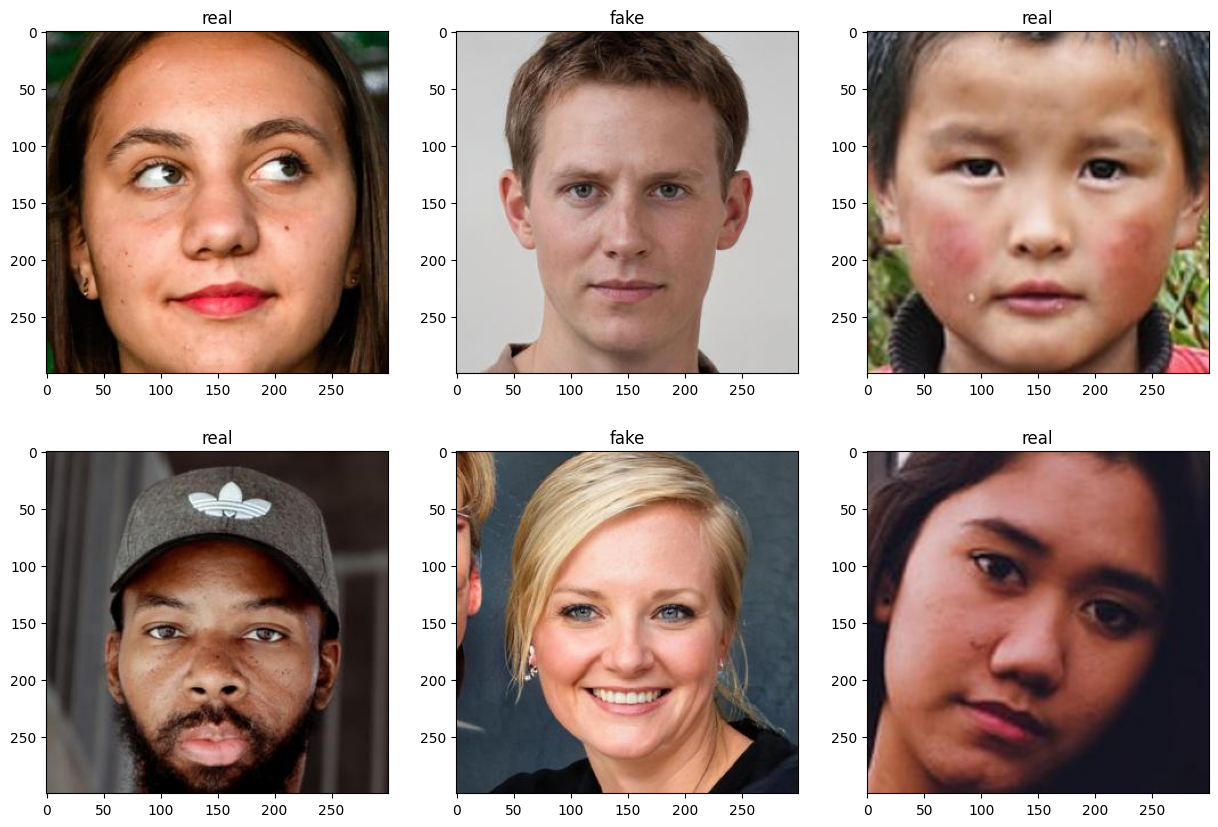

In [31]:
# show a sample of images with labels
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i in range(2):
    for j in range(3):
        random_idx = np.random.randint(0,df_test_2.shape[0],1)
        img = Image.open(df_test_2['path'].iloc[int(random_idx)])
        label = df_test_2['label'].iloc[int(random_idx)]
        axs[i,j].imshow(img)
        axs[i,j].set_title(label_arg[label])

In [32]:
#Preprocessing 

# Setting seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Setting constants
batch_size = 32
image_size = 224
channels = 3
shuffle_size = 256 

# Setting auto tune
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [33]:
# defining functions to decode image paths and preprocess images 
def read_img():
    def img_to_array(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=channels)
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, (image_size, image_size))
        image = image/255.0
        #image = tf.image.rgb_to_grayscale(image)
        return image
    def mapping(path, score):
        return img_to_array(path), score
    return mapping

def augment(image, score):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.95, 1.05)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_crop(image, (200, 200, 3))
    image = tf.image.resize(image, (image_size, image_size))
    return image, score

def preprocess(ds, batch_size, ds_type):
    read_img_fn = read_img()
    ds = ds.map(read_img_fn, num_parallel_calls=AUTOTUNE)
    if ds_type=='train':
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(shuffle_size, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

# define a function that creates a tesnorflow dataset
def create_ds(X,y, ds_type):
    ds = Dataset.from_tensor_slices((X,y))
    ds = preprocess(ds, batch_size, ds_type)
    return ds

In [34]:
# create tensorflow datasets for train, validation and test

Train_ds = create_ds(X_train, y_train, 'train')
Val_ds = create_ds(X_val, y_val, 'train')
Test_ds = create_ds(X_test, y_test, 'test')

In [35]:
# create the second testing tensorflow dataset
Test_ds_2 = create_ds(df_test_2['path'],df_test_2['label'], 'test')

In [36]:
pretrained_model = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
print(pretrained_model.summary())


# freeze layers
pretrained_model.trainable=False
for layer in pretrained_model.layers[-5:]:
    if not isinstance(layer, layers.BatchNormalization):
           layer.trainable = True
#for layer in pretrained_model.layers[:-5]:
#    layer.trainable=False

# create new model
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss= tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), 
            optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
            metrics=['binary_accuracy'])



Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

None


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, Model

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
tf.test.gpu_device_name()


TensorFlow version: 2.20.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1760785044.977153   14937 gpu_device.cc:2020] Created device /device:GPU:0 with 4136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


'/device:GPU:0'

In [23]:
%%time
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, cooldown=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)
results = model.fit(Train_ds, epochs=20, batch_size=32, validation_data=Val_ds,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/20


2025-10-18 16:10:01.859491: I external/local_xla/xla/service/service.cc:163] XLA service 0x74389c014ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-18 16:10:01.859522: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-10-18 16:10:01.995622: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-18 16:10:03.048903: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-18 16:10:03.309879: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-18 16:10:04.

   3/3125 ━━━━━━━━━━━━━━━━━━━━ 3:26 66ms/step - binary_accuracy: 0.5122 - loss: 0.7982 

I0000 00:00:1760784010.268570   12972 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 248s 76ms/step - binary_accuracy: 0.9965 - loss: 0.2213 - val_binary_accuracy: 0.5008 - val_loss: 1.4254 - learning_rate: 1.0000e-04
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 259s 83ms/step - binary_accuracy: 0.9920 - loss: 0.2301 - val_binary_accuracy: 0.5008 - val_loss: 1.3205 - learning_rate: 1.0000e-04
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 296s 95ms/step - binary_accuracy: 0.9906 - loss: 0.2322 - val_binary_accuracy: 0.5008 - val_loss: 1.2404 - learning_rate: 1.0000e-04
Epoch 4/20
 756/3125 ━━━━━━━━━━━━━━━━━━━━ 4:29 114ms/step - binary_accuracy: 0.7933 - loss: 0.4190

KeyboardInterrupt: 

In [32]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import datetime

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 20
TRAIN_DIR = 'rvsf/real_vs_fake/real-vs-fake/train'
VAL_DIR = 'rvsf/real_vs_fake/real-vs-fake/valid'

AUTOTUNE = tf.data.AUTOTUNE

# Simple preprocessing without memory-intensive operations
def preprocess(image, label):
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    return image, label

# Training dataset (streaming batches)
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
).map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
).map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# Pretrained ResNet50V2
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

inputs = base_model.input
x = layers.Dense(64, activation='relu')(base_model.output)
x = layers.Dropout(0.3)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['binary_accuracy']
)

# Callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    TensorBoard(log_dir=log_dir),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


2025-10-18 16:29:41.646376: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 16:29:41.884412: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-18 16:29:43.824500: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Found 100000 files belonging to 2 classes.


I0000 00:00:1760785189.657938   16383 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 20000 files belonging to 2 classes.
Epoch 1/20


2025-10-18 16:29:56.306269: I external/local_xla/xla/service/service.cc:163] XLA service 0x700aac00eca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-18 16:29:56.306500: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-10-18 16:29:56.550644: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-18 16:29:57.621131: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-18 16:29:57.846578: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-18 16:29:58.

   2/3125 ━━━━━━━━━━━━━━━━━━━━ 3:04 59ms/step - binary_accuracy: 0.5156 - loss: 0.7774   

I0000 00:00:1760785204.387290   16557 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 293s 90ms/step - binary_accuracy: 0.7159 - loss: 0.5576 - val_binary_accuracy: 0.7814 - val_loss: 0.4696 - learning_rate: 1.0000e-04
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 366s 117ms/step - binary_accuracy: 0.7842 - loss: 0.4701 - val_binary_accuracy: 0.8149 - val_loss: 0.4189 - learning_rate: 1.0000e-04
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 397s 127ms/step - binary_accuracy: 0.8083 - loss: 0.4295 - val_binary_accuracy: 0.8277 - val_loss: 0.3910 - learning_rate: 1.0000e-04
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 409s 131ms/step - binary_accuracy: 0.8223 - loss: 0.4027 - val_binary_accuracy: 0.8379 - val_loss: 0.3741 - learning_rate: 1.0000e-04
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 416s 133ms/step - binary_accuracy: 0.8341 - loss: 0.3816 - val_binary_accuracy: 0.8435 - val_loss: 0.3617 - learning_rate: 1.0000e-04
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 430s 138ms/step - binary_accuracy: 0.8445 - loss: 0.3637 - val_binary_accuracy: 0.8505 - v

In [38]:
import matplotlib.pyplot as plt

# Extract number of epochs
epochs = range(1, len(history.history['loss']) + 1)

# Create figureimport tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Function to load and preprocess images from paths
def preprocess(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # or decode_png if PNG
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    return image, label

# Create test dataset from paths
Test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
Test_ds = Test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
Test_ds = Test_ds.batch(BATCH_SIZE)
Test_ds = Test_ds.prefetch(tf.data.AUTOTUNE)

# Evaluate overall loss and accuracy
loss, accuracy = model.evaluate(Test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Get predictions
y_pred = model.predict(Test_ds)
y_pred_classes = (y_pred > 0.5).astype(int)

# Classification report
print(classification_report(y_test.values, y_pred_classes, target_names=['Real', 'Fake']))


# ----------------------
# Plot Loss
# ----------------------
ax1.plot(epochs, history.history['loss'], 'o-', label='Train Loss', color='blue')
ax1.plot(epochs, history.history['val_loss'], 's-', label='Validation Loss', color='orange')
ax1.set_title('Training & Validation Loss', fontsize=14)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend(fontsize=12)

# ----------------------
# Plot Accuracy
# ----------------------
ax2.plot(epochs, history.history['binary_accuracy'], 'o-', label='Train Accuracy', color='green')
ax2.plot(epochs, history.history['val_binary_accuracy'], 's-', label='Validation Accuracy', color='red')
ax2.set_title('Training & Validation Accuracy', fontsize=14)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - binary_accuracy: 0.5263 - loss: 0.6998
Test Loss: 0.6998, Test Accuracy: 0.5263
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step
              precision    recall  f1-score   support

        Real       0.51      0.68      0.58      1935
        Fake       0.56      0.38      0.45      2065

    accuracy                           0.53      4000
   macro avg       0.53      0.53      0.52      4000
weighted avg       0.54      0.53      0.52      4000



<Figure size 640x480 with 0 Axes>

In [39]:
model.evaluate(Test_ds)

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - binary_accuracy: 0.5263 - loss: 0.6998


[0.6998066306114197, 0.5262500047683716]

In [40]:
model.evaluate(Test_ds_2)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - binary_accuracy: 0.3491 - loss: 0.7586


[0.7586069703102112, 0.3491078317165375]

In [41]:
# extract Test dataset true and predicted labels
true_labels=[]
pred_labels=[]
for batch in iter(Test_ds):
    true_labels.append(batch[1])
    pred = model.predict(batch[0])
    pred_labels.append(pred)

true_labels_np = np.concatenate(true_labels)
pred_labels_np = np.concatenate(pred_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━

2025-10-18 19:05:39.311587: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [42]:
# creat estimator class to wrap the tensorflow model as a sklearn classifier

class estimator:
    _estimator_type = ''
    classes_=[]
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_pred= self.model.predict(X)
        return y_pred.round()

classifier = estimator(model, ["real","fake"])

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step


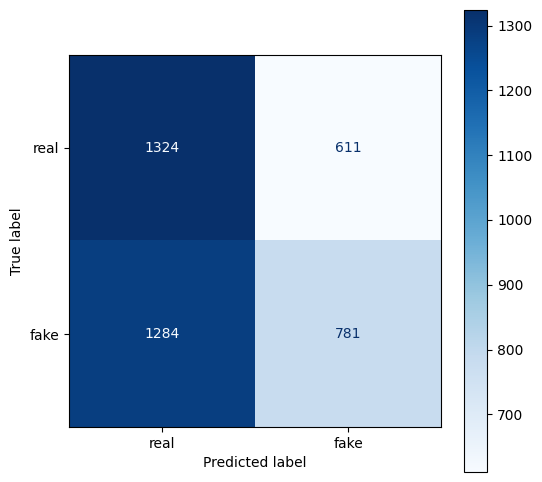

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Plot the confusion matrix for the Test dataset
fig, ax1 = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(
    classifier,
    X=Test_ds,
    y=true_labels_np,
    display_labels=["real", "fake"],
    cmap='Blues',
    ax=ax1
)
plt.show()